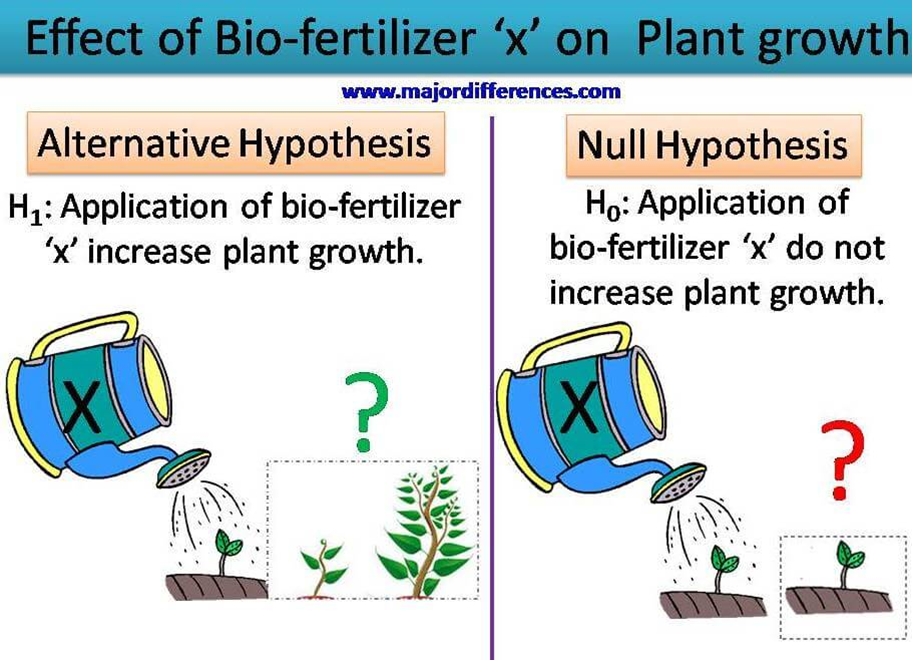

Use hypothesis testing to understand if there is any relationship between 2 features
Which hypothesis test to use when

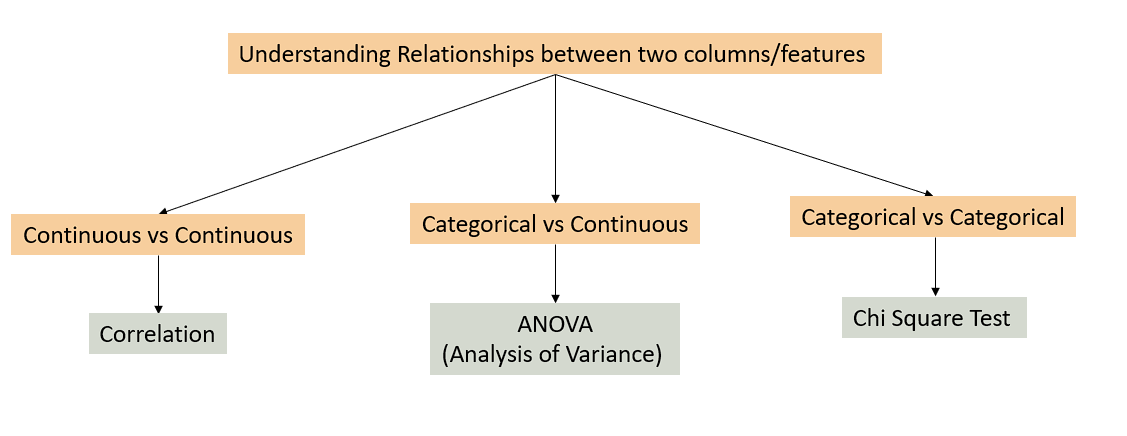

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import os
os.chdir('D:/')

In [3]:
import pandas as pd
df = pd.read_csv('tips.csv')
df.head()


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB


In [5]:
df.isna().sum()

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

In [6]:
df.duplicated().sum()

1

Seperate categorical and continuous features

In [7]:
cat = list(df.columns[df.dtypes=='object'])
con = list(df.columns[df.dtypes!='object'])

In [8]:
cat

['sex', 'smoker', 'day', 'time']

In [9]:
con

['total_bill', 'tip', 'size']

Continuous vs Continuous (Numerical) - Correlation

In [10]:
df[con].corr()

,total_bill,tip,size
total_bill,1.000000,0.675734,0.598315
tip,0.675734,1.000000,0.489299
size,0.598315,0.489299,1.000000


<Axes: >

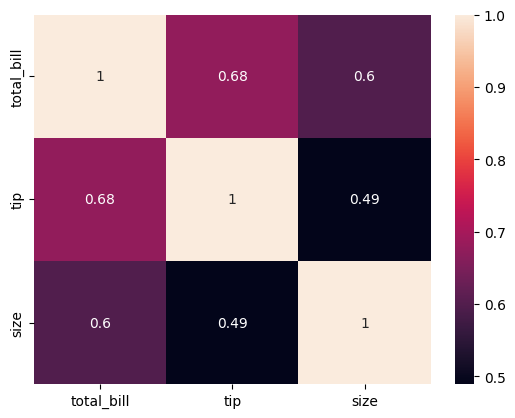

In [11]:
import seaborn as sns
sns.heatmap(df[con].corr(), annot=True)

Total bill and tip are positively correlated by 68%

Understanding relationship between categorical vs continuous features - ANOVA (ANalysis Of VAriance)

In [12]:
cat

['sex', 'smoker', 'day', 'time']

In [13]:
con

['total_bill', 'tip', 'size']

Trying to understand relationship between day(cat) and total_bill(con)

In [14]:
from statsmodels.formula.api import ols
model = ols("total_bill~C(day)", df).fit()

In [15]:
from statsmodels.stats.anova import anova_lm
Q = anova_lm(model)
Q

,df,sum_sq,mean_sq,F,PR(>F)
C(day),3.0,643.941362,214.647121,2.767479,0.042454
Residual,240.0,18614.522721,77.560511,NaN,NaN


if p_value = 0.3 , confidence_level= 1 - p_value = 1-0.3 = 70%
Two features are dependent on each other only is p_value<0.05 (95% confidence level)

In [16]:
p_value = Q.iloc[0, -1]
p_value

0.04245383328951916

In above test i can clearly say that p_value <=0.05 hence, Day and Total Bill are dependent on each other.

In [17]:
conf_level = 1-p_value
conf_level

0.9575461667104809

Create a function to get p_value from any two cat and con features

In [18]:
def ANOVA(df, cat_col, con_col):
    from statsmodels.formula.api import ols
    from statsmodels.stats.anova import anova_lm
    formula = f"{con_col}~C({cat_col})"
    model = ols(formula, df).fit()
    Q = anova_lm(model)
    p_value = round(Q.iloc[0, -1], 4)
    return p_value

In [19]:
ANOVA(df, "day", "tip")

0.1736

In above case p_value is not less than 0.05 , Day and Tip are NOT Dependent on each other

In [20]:
cat

['sex', 'smoker', 'day', 'time']

In [21]:
con

['total_bill', 'tip', 'size']

In [22]:
# Understanding if there is relationship between total_bill and all other cat features
for i in cat:
    p_val = ANOVA(df, i, "total_bill")
    print(f'p_value for {i} vs total_bill : {p_val}')

p_value for sex vs total_bill : 0.0236
p_value for smoker vs total_bill : 0.182
p_value for day vs total_bill : 0.0425
p_value for time vs total_bill : 0.0041


Total Bill is DEPENDENT on Gender, Day, Time (because p_val<=0.05)
Total Bill is NOT DEPENDENT on Smoker (because p_val>=0.05)

In [24]:
for i in cat:
    p_val = ANOVA(df, i, "tip")
    print(f'p_value for {i} vs tip : {p_val}')

p_value for sex vs tip : 0.1665
p_value for smoker vs tip : 0.9266
p_value for day vs tip : 0.1736
p_value for time vs tip : 0.0578


Tip is NOT DEPENDENT on Gender, smoker, day, time (becuse p_val>=0.05)

 Two features are Dependent on each other only if p_value is less than 0.05

Cat vs Cat - Chi Square Test

In [25]:
cat

['sex', 'smoker', 'day', 'time']

Trying to understand relationship between day and time

In [26]:

ctab = pd.crosstab(df['day'], df['time'])
ctab


time,Dinner,Lunch
day,,
Fri,12,7
Sat,87,0
Sun,76,0
Thur,1,61


In [27]:
from scipy.stats import chi2_contingency
chi = chi2_contingency(ctab)
chi

Chi2ContingencyResult(statistic=217.1126728434853, pvalue=8.449897551777147e-47, dof=3, expected_freq=array([[13.70491803,  5.29508197],
       [62.75409836, 24.24590164],
       [54.81967213, 21.18032787],
       [44.72131148, 17.27868852]]))

In [28]:
p_val = chi[1]
p_val

8.449897551777147e-47

In [29]:
round(p_val, 4)

0.0

Because p_value is less than 0.05 there is strong relationship between day and time

In [30]:
def chi_square(df, cat_col1, cat_col2):
    ctab = pd.crosstab(df[cat_col1], df[cat_col2])
    from scipy.stats import chi2_contingency
    chi = chi2_contingency(ctab)
    p_val = round(chi[1], 4)
    return p_val

In [31]:
cat

['sex', 'smoker', 'day', 'time']

In [33]:
chi_square(df, 'smoker', 'day')

0.0

Smoker and Day are dependent on each other becuase p_val<0.05

In [34]:
chi_square(df, 'smoker', 'time')

0.4771

Smoker and time are independent of each other p_val>0.05